# Imports

In [2]:
## imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

# company_index='5'
# company_name='Amazon'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'\
#             +f'{company_index}_{company_name}'
# img_path = root + '/Desktop/Paper/img'
# img_flag = False

# if not os.path.exists(img_path):
#     os.makedirs(img_path)

# Data Load

In [2]:
pc_flag = 'pro'


sentences = pd.\
read_csv(f'~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/{pc_flag}_doc_sampled_6_.csv')

# sentences = pd.\
# read_csv(f'~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/{pc_flag}_doc_all_px4.csv')

# sentences = pd.\
# read_csv(f'~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/{pc_flag}_doc_all.csv')


sentences.shape

(43311, 15)

In [3]:
sentences.head()

Unnamed: 0  Ratings  Job_Status  Reviewed_Year  \
0           0      4.0           0           2018   
1           1      1.0           0           2019   
2           2      3.0           1           2013   
3           3      5.0           0           2019   
4           4      4.0           0           2016   

                               Review_Text  \
0                Discount, health benefits   
1        1 hr and 30 minute break combined   
2                           flexible hours   
3                  Discounts, Hour lunches   
4  Hour lunch, decent pay, good co-workers   

                                            Px_Texts  \
0  benefit discount health discount_health health...   
1                        break hr minut minut_break    
2                         flexibl hour flexibl_hour    
3  discount hour lunch discount_hour hour_lunch d...   
4  cowork decent hour lunch pay decent_pay hour_l...   

                                          Tknz_Texts  Doc_Length  Work_Life  \
0  ['benefit', 'discount', 'health', 'discount_he...           5        4.0   
1            ['break', 'hr', 'minut', 'minut_break']           4        1.0   
2                ['flexibl', 'hour', 'flexibl_hour']           3        3.0   
3  ['discount', 'hour', 'lunch', 'discount_hour',...           6        5.0   
4  ['cowork', 'decent', 'hour', 'lunch', 'pay', '...          11        4.0   

   Benefits  Job_Advancement  Management  Culture  Company_Index Company_Name  
0       4.0              4.0         4.0      4.0              1      Walmart  
1       1.0              1.0         1.0      1.0              1      Walmart  
2       2.0              2.0         3.0      2.0              1      Walmart  
3       5.0              2.0         4.0      5.0              1      Walmart  
4       2.0              3.0         1.0      4.0              1      Walmart

In [5]:
# # display(sentences)
# sents = df.Px_Texts.values
# print(len(sents))
# count = 0
# for sent in sents[:5]:
#     if (len(sent.split()) <= 0) :
#         count += 1
# print(count)
        
    


# Tokenization

In [4]:
df = sentences.copy()

data_px = [sents.split() for sents in df.Px_Texts.values]
print(len(data_px))
# data_px = df['Px_Texts'].str.split().values
# data_px


43311


In [5]:
data_px[:2]

[['benefit', 'discount', 'health', 'discount_health', 'health_benefit'],
 ['break', 'hr', 'minut', 'minut_break']]

# Build Dictionary

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_px) ##dictionary
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]  ##corpus

# View
print(corpus[:5])

12924
Dictionary(12924 unique tokens: ['benefit', 'discount', 'discount_health', 'health', 'health_benefit']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1)], [(1, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(11, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


# LDA

In [9]:
def lda_viz(num_topics): 

    # %%time
    # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    num_topics = num_topics
    mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
#     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=500, random_seed=42)
    %time ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)


    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


    ##mallet model to lda model conversion
    optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

    # %%time
    # Visualize the topics
    pyLDAvis.enable_notebook()
    # vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
    vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
    return vis
    # pyLDAvis.show(vis)

In [10]:
# viz = lda_viz(10)
# viz

# Finding Optimal Model

In [36]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                  random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [52]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=8, limit=30, step=2)

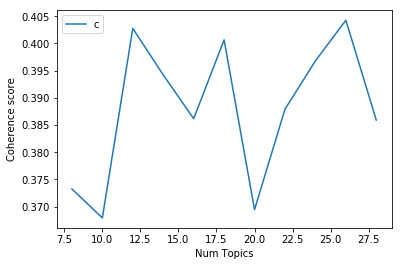

In [53]:
# Show graph
limit=30; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 8  has Coherence Value of 0.3733
Num Topics = 10  has Coherence Value of 0.3679
Num Topics = 12  has Coherence Value of 0.4028
Num Topics = 14  has Coherence Value of 0.3942
Num Topics = 16  has Coherence Value of 0.3862
Num Topics = 18  has Coherence Value of 0.4007
Num Topics = 20  has Coherence Value of 0.3694
Num Topics = 22  has Coherence Value of 0.3879
Num Topics = 24  has Coherence Value of 0.3968
Num Topics = 26  has Coherence Value of 0.4043
Num Topics = 28  has Coherence Value of 0.3859


# Optimal Model Visualization

In [20]:
vis = lda_viz(12)
vis


Coherence Score:  0.3530280031384962


/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.173001 -0.103659       1        1  8.538370
5      0.139786  0.326360       2        1  8.377995
1     -0.213499 -0.027404       3        1  8.377230
6      0.137494 -0.139530       4        1  8.351030
9      0.182956  0.235521       5        1  8.349216
10    -0.233662 -0.028881       6        1  8.324815
0     -0.179354  0.148503       7        1  8.312941
3      0.166535 -0.127177       8        1  8.299041
11     0.159529 -0.149045       9        1  8.277754
7     -0.276401 -0.006538      10        1  8.277169
4     -0.060751 -0.094470      11        1  8.275591
8      0.004368 -0.033680      12        1  8.238848, topic_info=    Category         Freq     Term        Total  loglift  logprob
40   Default  3193.000000     free  3193.000000  30.0000  30.0000
0    Default  8004.000000  benefit  8004.000000  29.0000  29.0000
22   Default  4959.000000      pay  4959.000000  28.0000  28.0000
15   Default  2383.000000    lunch  2383.000000  27.0000  27.0000
11   Default  2007.000000     hour  2007.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
281  Topic12   147.557025       na   193.409935   2.2257  -4.3954
22   Topic12   792.203317      pay  4959.786874   0.6620  -2.7148
238  Topic12    89.999320  weekend   148.246649   1.9972  -4.8898
423  Topic12   109.882891   reward   223.555043   1.7861  -4.6902
204  Topic12    75.348268      set   131.658397   1.9382  -5.0675

[847 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
136       4  0.999788     15_minut_break
27        4  0.976559       1_hour_lunch
27       12  0.016837       1_hour_lunch
4874      6  0.971091  401k_health_insur
113       9  0.973323               abil
...     ...       ...                ...
2025     12  0.975361            workout
6254     10  1.013206    workplac_cultur
416       2  0.999631              world
1040      2  1.013071                 ye
1949      2  1.013071                  ’

[995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 7, 10, 11, 1, 4, 12, 8, 5, 9])

In [56]:
vis = lda_viz(26)
vis


Coherence Score:  0.37988354408079655


/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.129088 -0.301673       1        1  4.061888
0     -0.065445  0.050558       2        1  3.967950
16    -0.136105 -0.279961       3        1  3.907562
6     -0.140085 -0.329457       4        1  3.899615
20    -0.095750 -0.096567       5        1  3.891754
3     -0.084132  0.144798       6        1  3.869052
8     -0.084668 -0.092491       7        1  3.865254
17    -0.075086  0.105321       8        1  3.849540
21    -0.077559  0.105906       9        1  3.848897
13    -0.035068  0.074843      10        1  3.843747
5     -0.076649  0.098984      11        1  3.836836
2     -0.071697  0.142858      12        1  3.829271
4     -0.070976  0.085040      13        1  3.828860
18     0.031550  0.037081      14        1  3.826098
12    -0.064141  0.061317      15        1  3.823591
7     -0.078487  0.058001      16        1  3.819009
14     0.122207  0.028434      17        1  3.818582
15    -0.051604  0.058748      18        1  3.818458
19    -0.078366  0.098849      19        1  3.818003
9      0.364276 -0.043384      20        1  3.817530
11     0.296435 -0.020022      21        1  3.815091
25    -0.031611 -0.082074      22        1  3.814542
24    -0.081268  0.107256      23        1  3.801127
23     0.400475 -0.044954      24        1  3.791227
22    -0.070259  0.075382      25        1  3.790127
10     0.383100 -0.042792      26        1  3.746388, topic_info=      Category          Freq             Term         Total  loglift  logprob
2      Default  58173.000000          benefit  58173.000000  30.0000  30.0000
28     Default  38699.000000              pay  38699.000000  29.0000  29.0000
13     Default  26149.000000            lunch  26149.000000  28.0000  28.0000
25     Default  23425.000000             hour  23425.000000  27.0000  27.0000
43     Default  21247.000000            peopl  21247.000000  26.0000  26.0000
101    Default  20615.000000         discount  20615.000000  25.0000  25.0000
5      Default  21184.000000             free  21184.000000  24.0000  24.0000
10     Default  16048.000000            break  16048.000000  23.0000  23.0000
45     Default  11952.000000          flexibl  11952.000000  22.0000  22.0000
161    Default  11674.000000            manag  11674.000000  21.0000  21.0000
103    Default  11399.000000           cowork  11399.000000  20.0000  20.0000
9      Default  11374.000000             time  11374.000000  19.0000  19.0000
41     Default  12060.000000          environ  12060.000000  18.0000  18.0000
106    Default   9403.000000          schedul   9403.000000  17.0000  17.0000
4      Default  10465.000000          employe  10465.000000  16.0000  16.0000
214    Default   8362.000000       free_lunch   8362.000000  15.0000  15.0000
16     Default   9290.000000           custom   9290.000000  14.0000  14.0000
59     Default   7616.000000         friendli   7616.000000  13.0000  13.0000
99     Default   7416.000000              fun   7416.000000  12.0000  12.0000
84     Default   7376.000000             paid   7376.000000  11.0000  11.0000
90     Default   7262.000000            learn   7262.000000  10.0000  10.0000
118    Default   7222.000000             nice   7222.000000   9.0000   9.0000
251    Default   7200.000000             team   7200.000000   8.0000   8.0000
82     Default   6976.000000         opportun   6976.000000   7.0000   7.0000
24     Default   6868.000000              day   6868.000000   6.0000   6.0000
142    Default   6795.000000           advanc   6795.000000   5.0000   5.0000
40     Default   7924.000000       hour_lunch   7924.000000   4.0000   4.0000
483    Default   5478.000000             home   5478.000000   3.0000   3.0000
52     Default   5443.000000             food   5443.000000   2.0000   2.0000
11     Default   5405.000000           health   5405.000000   1.0000   1.0000
...        ...           ...              ...          

## Topic Composition

In [15]:
num_topics = 12

mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)

optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [16]:
# Print the topics
model_topics = optimal_model.show_topics(formatted=True, num_topics=num_topics)
# pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(0,
  '0.222*"peopl" + 0.058*"benefit" + 0.040*"meet" + 0.035*"bonus" + '
  '0.033*"overtim" + 0.024*"incent" + 0.019*"wage" + 0.019*"differ" + '
  '0.018*"perk" + 0.018*"love"'),
 (1,
  '0.172*"benefit" + 0.119*"time" + 0.087*"pay" + 0.071*"paid" + 0.064*"day" + '
  '0.047*"vacat" + 0.032*"holiday" + 0.014*"paid_time" + 0.012*"vacat_time" + '
  '0.011*"rais"'),
 (2,
  '0.258*"free" + 0.193*"lunch" + 0.092*"free_lunch" + 0.027*"drink" + '
  '0.023*"coffe" + 0.016*"free_coffe" + 0.015*"snack" + 0.014*"sometim" + '
  '0.013*"free_drink" + 0.011*"meal"'),
 (3,
  '0.122*"manag" + 0.096*"cowork" + 0.076*"team" + 0.062*"friendli" + '
  '0.061*"custom" + 0.027*"support" + 0.024*"servic" + 0.024*"staff" + '
  '0.021*"awesom" + 0.020*"posit"'),
 (4,
  '0.064*"cultur" + 0.043*"experi" + 0.038*"healthcar" + 0.023*"bonu" + '
  '0.021*"challeng" + 0.018*"divers" + 0.017*"technolog" + 0.016*"travel" + '
  '0.016*"na" + 0.012*"safeti"'),
 (5,
  '0.068*"nice" + 0.063*"food" + 0.032*"free_food" + 0.02

In [18]:
for i, row in enumerate(optimal_model[corpus]):
    print(row)

[(0, 0.07697558585297869), (1, 0.07946975471898465), (2, 0.07575757575758216), (3, 0.07575757575758216), (4, 0.07575757575758216), (5, 0.07575857718512413), (6, 0.09393939393940143), (7, 0.08032663965601544), (8, 0.07575757575758216), (9, 0.07575757575758216), (10, 0.1389845941020029), (11, 0.07575757575758216)]
[(0, 0.07716049382716174), (1, 0.07716049382716174), (2, 0.07716049382716174), (3, 0.0955216615944199), (4, 0.07716049382716174), (5, 0.07716049382716174), (6, 0.13287340013396298), (7, 0.07716049382716174), (8, 0.07716049382716174), (9, 0.07716049382716174), (10, 0.07716049382716174), (11, 0.07716049382716174)]
[(0, 0.07861635220125798), (1, 0.07861635220125798), (2, 0.07861635220125798), (3, 0.07861635220125798), (4, 0.07861635220125798), (5, 0.07861635220125798), (6, 0.07861635220125798), (7, 0.07861635220125798), (8, 0.07861635220125798), (9, 0.07861635220125798), (10, 0.07861635220125798), (11, 0.13522012578616238)]
[(0, 0.07440476190484686), (1, 0.07440476190484686), (2, 

[(0, 0.07861635220127379), (1, 0.07861635220127379), (2, 0.07861635220127379), (3, 0.08152540666561155), (4, 0.07861635220127379), (5, 0.09458194321523249), (6, 0.116345480307692), (7, 0.07861635220127379), (8, 0.07861635220127379), (9, 0.07861635220127379), (10, 0.07861635220127379), (11, 0.07861635220127379)]
[(0, 0.0816993464052288), (1, 0.0816993464052288), (2, 0.0816993464052288), (3, 0.0816993464052288), (4, 0.0816993464052288), (5, 0.0816993464052288), (6, 0.0816993464052288), (7, 0.0816993464052288), (8, 0.1013071895424834), (9, 0.0816993464052288), (10, 0.0816993464052288), (11, 0.0816993464052288)]
[(0, 0.06944444444447208), (1, 0.07435047633110357), (2, 0.08611111111114512), (3, 0.06944789098733758), (4, 0.06944444444447208), (5, 0.06944444444447208), (6, 0.1645349660146258), (7, 0.06944444444447208), (8, 0.06944444444447208), (9, 0.06944444444447208), (10, 0.06944444444447208), (11, 0.1194444444444836)]
[(0, 0.08169934640522934), (1, 0.08169934640522934), (2, 0.081699346405

[(0, 0.08333333333333336), (1, 0.08333333333333336), (2, 0.08333333333333336), (3, 0.08333333333333336), (4, 0.08333333333333336), (5, 0.08333333333333336), (6, 0.08333333333333336), (7, 0.08333333333333336), (8, 0.08333333333333336), (9, 0.08333333333333336), (10, 0.08333333333333336), (11, 0.08333333333333336)]
[(0, 0.07864960082365907), (1, 0.07861635220125793), (2, 0.13518687716376185), (3, 0.07861635220125793), (4, 0.07861635220125793), (5, 0.07861635220125793), (6, 0.07861635220125793), (7, 0.07861635220125793), (8, 0.07861635220125793), (9, 0.07861635220125793), (10, 0.07861635220125793), (11, 0.07861635220125793)]
[(0, 0.08169934640522945), (1, 0.08169934640522945), (2, 0.08169934640522945), (3, 0.08169934640522945), (4, 0.08169934640522945), (5, 0.08169934640522945), (6, 0.08169934640522945), (7, 0.08169934640522945), (8, 0.08169934640522945), (9, 0.08169934640522945), (10, 0.08169934640522945), (11, 0.10130718954247624)]
[(0, 0.07716049382720759), (1, 0.07716049382720759), (2

[(0, 0.07575757575757619), (1, 0.07575757575757619), (2, 0.07575757575757619), (3, 0.11210841530778734), (4, 0.07575757575757619), (5, 0.07575757575757619), (6, 0.07577037257100075), (7, 0.13030303030302645), (8, 0.07575757575757619), (9, 0.07575757575757619), (10, 0.07575757575757619), (11, 0.07575757575757619)]
[(0, 0.07062146892658039), (1, 0.07063012636777191), (2, 0.07062146892658039), (3, 0.10448783940597922), (4, 0.08108706738547802), (5, 0.07062146892658039), (6, 0.13008810255154238), (7, 0.07075830240671269), (8, 0.1190770805762938), (9, 0.07062146892658039), (10, 0.07076413667332024), (11, 0.07062146892658039)]
[(0, 0.0786163522012595), (1, 0.0786163522012595), (2, 0.0786163522012595), (3, 0.0786163522012595), (4, 0.0786163522012595), (5, 0.11635220125784425), (6, 0.0786163522012595), (7, 0.09748427672956098), (8, 0.0786163522012595), (9, 0.0786163522012595), (10, 0.0786163522012595), (11, 0.0786163522012595)]
[(0, 0.07309941520475169), (1, 0.07309941520475169), (2, 0.0906432

[(0, 0.07999757210626307), (1, 0.08626635231528373), (2, 0.07861635220125791), (3, 0.07861635220125791), (4, 0.07861635220125791), (5, 0.07861748593730614), (6, 0.07861635220125791), (7, 0.11841253907904743), (8, 0.08093885279710074), (9, 0.07861635220125791), (10, 0.08406908455745148), (11, 0.07861635220125791)]
[(0, 0.07861635220125825), (1, 0.07861635220125825), (2, 0.07861635220125825), (3, 0.07861635220125825), (4, 0.07861635220125825), (5, 0.07861635220125825), (6, 0.07861635220125825), (7, 0.07861635220125825), (8, 0.07861635220125825), (9, 0.07861635220125825), (10, 0.1352201257861594), (11, 0.07861635220125825)]
[(0, 0.0801282051282052), (1, 0.10400639184837679), (2, 0.0801282051282052), (3, 0.0801282051282052), (4, 0.0801282051282052), (5, 0.0801282051282052), (6, 0.0801282051282052), (7, 0.09192144830263427), (8, 0.082918313695142), (9, 0.0801282051282052), (10, 0.0801282051282052), (11, 0.0801282051282052)]
[(0, 0.08169934640522883), (1, 0.08169934640522883), (2, 0.08169934

[(0, 0.1013071895424824), (1, 0.08169934640522888), (2, 0.08169934640522888), (3, 0.08169934640522888), (4, 0.08169934640522888), (5, 0.08169934640522888), (6, 0.08169934640522888), (7, 0.08169934640522888), (8, 0.08169934640522888), (9, 0.08169934640522888), (10, 0.08169934640522888), (11, 0.08169934640522888)]
[(0, 0.09393939393941418), (1, 0.07577879846349819), (2, 0.07575757575759325), (3, 0.13028180759714098), (4, 0.07575757575759325), (5, 0.07575757575759325), (6, 0.09393939393920091), (7, 0.07575757575759325), (8, 0.07575757575759325), (9, 0.07575757575759325), (10, 0.07575757575759325), (11, 0.07575757575759325)]
[(0, 0.08012820512820525), (1, 0.08016024170973947), (2, 0.08012820512820525), (3, 0.0993269377774395), (4, 0.08012820512820525), (5, 0.08012820512820525), (6, 0.09935897435897403), (7, 0.08012820512820525), (8, 0.08012820512820525), (9, 0.08012820512820525), (10, 0.08012820512820525), (11, 0.08012820512820525)]
[(0, 0.07309941520468055), (1, 0.07660192743213462), (2, 

[(0, 0.09121928993006435), (1, 0.12797232041244602), (2, 0.07440476190476399), (3, 0.07440863196850826), (4, 0.07492735730292321), (5, 0.08501658057801745), (6, 0.07440476190476399), (7, 0.07440476190476399), (8, 0.08323204677696323), (9, 0.07440476190476399), (10, 0.07440476190476399), (11, 0.09119996350725776)]
[(0, 0.08169934640522906), (1, 0.08169934640522906), (2, 0.08169934640522906), (3, 0.08169934640522906), (4, 0.08169934640522906), (5, 0.10130718954248044), (6, 0.08169934640522906), (7, 0.08169934640522906), (8, 0.08169934640522906), (9, 0.08169934640522906), (10, 0.08169934640522906), (11, 0.08169934640522906)]
[(0, 0.07716049382716714), (1, 0.09567328433244257), (2, 0.07716049382716714), (3, 0.07716622184041144), (4, 0.07716049382716714), (5, 0.07716049382716714), (6, 0.07716049382716714), (7, 0.09567901234560952), (8, 0.09567901234568102), (9, 0.09567901234568543), (10, 0.07716049382716714), (11, 0.07716049382716714)]
[(0, 0.080128205128212), (1, 0.080128205128212), (2, 0.

[(0, 0.07575757575764681), (1, 0.0789133209687039), (2, 0.07575757575764681), (3, 0.11212121212128696), (4, 0.07575757575764681), (5, 0.07575757575764681), (6, 0.07575757575764681), (7, 0.10661357192626413), (8, 0.07814312456628426), (9, 0.07575757575764681), (10, 0.09390574011393332), (11, 0.07575757575764681)]
[(0, 0.07575757575757822), (1, 0.1171287431458448), (2, 0.07575757575757822), (3, 0.07582773152186231), (4, 0.07575757575757822), (5, 0.11155578557017135), (6, 0.07575757575757822), (7, 0.08634528280937373), (8, 0.07827400009867076), (9, 0.07632300230860777), (10, 0.07575757575757822), (11, 0.07575757575757822)]
[(0, 0.07443624181952398), (1, 0.09226190476110845), (2, 0.12794471056182558), (3, 0.07440476190490816), (4, 0.07440476190490816), (5, 0.07440476190490816), (6, 0.07440476190490816), (7, 0.07440476190490816), (8, 0.09226190476208486), (9, 0.09226190476110008), (10, 0.07440476190490816), (11, 0.07440476190490816)]
[(0, 0.10130718954248066), (1, 0.08169934640522905), (2, 

[(0, 0.0816993464052288), (1, 0.0816993464052288), (2, 0.0816993464052288), (3, 0.0816993464052288), (4, 0.0816993464052288), (5, 0.0816993464052288), (6, 0.0816993464052288), (7, 0.0816993464052288), (8, 0.0816993464052288), (9, 0.0816993464052288), (10, 0.0816993464052288), (11, 0.10130718954248343)]
[(0, 0.08169934640522881), (1, 0.08169934640522881), (2, 0.08169934640522881), (3, 0.08169934640522881), (4, 0.08169934640522881), (5, 0.08169934640522881), (6, 0.10130718954248329), (7, 0.08169934640522881), (8, 0.08169934640522881), (9, 0.08169934640522881), (10, 0.08169934640522881), (11, 0.08169934640522881)]
[(0, 0.07861635220125798), (1, 0.07861635220125798), (2, 0.07861635220125798), (3, 0.07861635220125798), (4, 0.07861635220125798), (5, 0.07861635220125798), (6, 0.07861635220125798), (7, 0.07861635220125798), (8, 0.07861635220125798), (9, 0.07861635220125798), (10, 0.07861635220125798), (11, 0.13522012578616238)]
[(0, 0.08169934640522881), (1, 0.08169934640522881), (2, 0.0816993

[(0, 0.0799975555501845), (1, 0.08626528242160568), (2, 0.07861635220125791), (3, 0.07861635220125791), (4, 0.07861635220125791), (5, 0.07861748592570779), (6, 0.07861635220125791), (7, 0.11841380275745139), (8, 0.08093871879545056), (9, 0.07861635220125791), (10, 0.0840690413420527), (11, 0.07861635220125791)]
[(0, 0.07164181388258675), (1, 0.07582222676002381), (2, 0.07062146892656013), (3, 0.07062146892656013), (4, 0.07068606830630643), (5, 0.07062230934621234), (6, 0.07062146892656013), (7, 0.16025229611470226), (8, 0.08936053341446368), (9, 0.07062146892656013), (10, 0.0746091024581622), (11, 0.10451977401130193)]
[(0, 0.07441452060364512), (1, 0.07440476190476318), (2, 0.11010928892016471), (3, 0.07440476190476318), (4, 0.07440476190476318), (5, 0.11011904761904767), (6, 0.09226190476189472), (7, 0.07440476190476318), (8, 0.07440476190476318), (9, 0.09226190476190561), (10, 0.07440476190476318), (11, 0.07440476190476318)]
[(0, 0.07729065323936643), (1, 0.08047292813700138), (2, 0

[(0, 0.08012820512820892), (1, 0.08012820512820892), (2, 0.09296658924094292), (3, 0.08012820512820892), (4, 0.08012820512820892), (5, 0.09935897435897831), (6, 0.08652059024619865), (7, 0.08012820512820892), (8, 0.08012820512820892), (9, 0.08012820512820892), (10, 0.08012820512820892), (11, 0.08012820512820892)]
[(0, 0.08012820512820587), (1, 0.08012820512820587), (2, 0.09935897435896904), (3, 0.08012820512820587), (4, 0.09884211485093967), (5, 0.08012820512820587), (6, 0.08064506463623865), (7, 0.08012820512820587), (8, 0.08012820512820587), (9, 0.08012820512820587), (10, 0.08012820512820587), (11, 0.08012820512820587)]
[(0, 0.07576407995650691), (1, 0.07575757575757729), (2, 0.1666364437758195), (3, 0.07575757575757729), (4, 0.07575757575757729), (5, 0.07575757575757729), (6, 0.07575757575757729), (7, 0.07575757575757729), (8, 0.07575757575757729), (9, 0.07578129444947818), (10, 0.07575757575757729), (11, 0.07575757575757729)]
[(0, 0.07440476190476471), (1, 0.07440476190476471), (2,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[(0, 0.08020774672009322), (1, 0.08350534954118927), (2, 0.07861635220125858), (3, 0.07861635220125858), (4, 0.07861635220125858), (5, 0.07861765428608908), (6, 0.07861635220125858), (7, 0.08466004109686642), (8, 0.07861635220125858), (9, 0.07861635220125858), (10, 0.08495889389035692), (11, 0.11635220125785349)]
[(0, 0.0799823486019533), (1, 0.08279208351940971), (2, 0.07861635220125837), (3, 0.07861635220125837), (4, 0.07861635220125837), (5, 0.07861747368352769), (6, 0.07861635220125837), (7, 0.12428836468346409), (8, 0.07861635220125837), (9, 0.07861635220125837), (10, 0.08400526410283667), (11, 0.07861635220125837)]
[(0, 0.07590999154372906), (1, 0.07904242841745404), (2, 0.0744047619047641), (3, 0.127836375249925), (4, 0.11011904761902887), (5, 0.07440599385234549), (6, 0.0744047619047641), (7, 0.08012620079285102), (8, 0.0744047619047641), (9, 0.07447902919406785), (10, 0.0804618857115425), (11, 0.0744047619047641)]
[(0, 0.08012820512820527), (1, 0.08012820512820527), (2, 0.080

[(0, 0.08335265735580695), (1, 0.08678611552781032), (2, 0.08169934640522877), (3, 0.08169934640522877), (4, 0.08169934640522877), (5, 0.08170069958401788), (6, 0.08169934640522877), (7, 0.08798725141331688), (8, 0.08169934640522877), (9, 0.08169934640522877), (10, 0.08827785128244668), (11, 0.08169934640522877)]
[(0, 0.07062146892655637), (1, 0.12146524188577455), (2, 0.08757062146892965), (3, 0.07082921506628613), (4, 0.08736655999706838), (5, 0.07062146892655637), (6, 0.08757062146892942), (7, 0.07062146892655637), (8, 0.08757062146892859), (9, 0.07062146892655637), (10, 0.07062146892655637), (11, 0.10451977401130161)]
[(0, 0.08335292570626464), (1, 0.08678551475858574), (2, 0.08169934640522877), (3, 0.08169934640522877), (4, 0.08169934640522877), (5, 0.08170069961555765), (6, 0.08169934640522877), (7, 0.08798789831546985), (8, 0.08169934640522877), (9, 0.08169934640522877), (10, 0.08827753676752083), (11, 0.08169934640522877)]
[(0, 0.08333333333333336), (1, 0.08333333333333336), (2

[(0, 0.0816993464052288), (1, 0.0816993464052288), (2, 0.0816993464052288), (3, 0.0816993464052288), (4, 0.0816993464052288), (5, 0.0816993464052288), (6, 0.0816993464052288), (7, 0.0816993464052288), (8, 0.0816993464052288), (9, 0.0816993464052288), (10, 0.0816993464052288), (11, 0.10130718954248341)]
[(0, 0.08335293109287932), (1, 0.08678330054722781), (2, 0.08169934640522877), (3, 0.08169934640522877), (4, 0.08169934640522877), (5, 0.0817006995827821), (6, 0.08169934640522877), (7, 0.08798695736364134), (8, 0.08169934640522877), (9, 0.08169934640522877), (10, 0.08828068657686812), (11, 0.08169934640522877)]
[(0, 0.07871318539151557), (1, 0.08466618095477337), (2, 0.07716049382716153), (3, 0.07716049382716153), (4, 0.07716049382716153), (5, 0.09548690158554234), (6, 0.07716049382716153), (7, 0.11621980404822858), (8, 0.07943985575207993), (9, 0.07716049382716153), (10, 0.08251110930489117), (11, 0.07716049382716153)]
[(0, 0.0817750921452303), (1, 0.0801282051282091), (2, 0.0801282051

[(0, 0.08169934640522877), (1, 0.08561123339918685), (2, 0.08169934640522877), (3, 0.08169934640522877), (4, 0.08169934640522877), (5, 0.08169934640522877), (6, 0.08169934640522877), (7, 0.09441040820375211), (8, 0.08468424075000215), (9, 0.08169934640522877), (10, 0.08169934640522877), (11, 0.08169934640522877)]
[(0, 0.07440476190477242), (1, 0.07440476190477242), (2, 0.07440476190477242), (3, 0.07440476190477242), (4, 0.07440476190477242), (5, 0.07440476190477242), (6, 0.1815476190475037), (7, 0.07440476190477242), (8, 0.07440476190477242), (9, 0.07440476190477242), (10, 0.07440476190477242), (11, 0.07440476190477242)]
[(0, 0.07861635220125823), (1, 0.07861635220125823), (2, 0.07861635220125823), (3, 0.09748427672955755), (4, 0.07861635220125823), (5, 0.09736511490153908), (6, 0.07861635220125823), (7, 0.07861635220125823), (8, 0.09748427672955892), (9, 0.07861635220125823), (10, 0.07873551402927868), (11, 0.07861635220125823)]
[(0, 0.09935897435897297), (1, 0.080128205128206), (2, 0

[(0, 0.08333333333333336), (1, 0.08333333333333336), (2, 0.08333333333333336), (3, 0.08333333333333336), (4, 0.08333333333333336), (5, 0.08333333333333336), (6, 0.08333333333333336), (7, 0.08333333333333336), (8, 0.08333333333333336), (9, 0.08333333333333336), (10, 0.08333333333333336), (11, 0.08333333333333336)]
[(0, 0.08169934640522883), (1, 0.08169934640522883), (2, 0.08169934640522883), (3, 0.08171072641268423), (4, 0.10129580953502762), (5, 0.08169934640522883), (6, 0.08169934640522883), (7, 0.08169934640522883), (8, 0.08169934640522883), (9, 0.08169934640522883), (10, 0.08169934640522883), (11, 0.08169934640522883)]
[(0, 0.07440476190477993), (1, 0.07440476190477993), (2, 0.07440476190477993), (3, 0.07440476190477993), (4, 0.07440476190477993), (5, 0.07440476190477993), (6, 0.07440476190477993), (7, 0.07441278241255339), (8, 0.07440476190477993), (9, 0.07440476190477993), (10, 0.16368245568250073), (11, 0.09226190476192653)]
[(0, 0.0801282051282863), (1, 0.0801282051282863), (2, 

[(0, 0.08333333333333336), (1, 0.08333333333333336), (2, 0.08333333333333336), (3, 0.08333333333333336), (4, 0.08333333333333336), (5, 0.08333333333333336), (6, 0.08333333333333336), (7, 0.08333333333333336), (8, 0.08333333333333336), (9, 0.08333333333333336), (10, 0.08333333333333336), (11, 0.08333333333333336)]
[(0, 0.0816993464052288), (1, 0.0816993464052288), (2, 0.0816993464052288), (3, 0.0816993464052288), (4, 0.0816993464052288), (5, 0.0816993464052288), (6, 0.0816993464052288), (7, 0.0816993464052288), (8, 0.1013071895424834), (9, 0.0816993464052288), (10, 0.0816993464052288), (11, 0.0816993464052288)]
[(0, 0.07851616569014137), (1, 0.0846702393188874), (2, 0.07716049382716059), (3, 0.07716049382716059), (4, 0.07716049382716059), (5, 0.07716160659027645), (6, 0.07716049382716059), (7, 0.1162171522992914), (8, 0.07944037665373581), (9, 0.07716049382716059), (10, 0.08251297796618609), (11, 0.09567901234567859)]
[(0, 0.08169934640522901), (1, 0.08169934640522901), (2, 0.0816993464

[(0, 0.09762170768030988), (1, 0.08185727600656352), (2, 0.07716049382716245), (3, 0.07716049382716245), (4, 0.11419753086417861), (5, 0.07716174521393289), (6, 0.07716049382716245), (7, 0.08296103652347454), (8, 0.07716049382716245), (9, 0.07716049382716245), (10, 0.08323774074856603), (11, 0.07716049382716245)]
[(0, 0.07440476190476224), (1, 0.07440476190476224), (2, 0.07440476190476224), (3, 0.07440476190476224), (4, 0.07440476190476224), (5, 0.07440476190476224), (6, 0.07440476190476224), (7, 0.07440476190476224), (8, 0.07440476190476224), (9, 0.07440476190476224), (10, 0.07440476190476224), (11, 0.1815476190476155)]
[(0, 0.08012820512820536), (1, 0.09935897435897398), (2, 0.08012820512820536), (3, 0.08012820512820536), (4, 0.08012820512820536), (5, 0.08012820512820536), (6, 0.09921417147999036), (7, 0.08012820512820536), (8, 0.08012820512820536), (9, 0.08012820512820536), (10, 0.08012820512820536), (11, 0.08027300800718758)]
[(0, 0.0786163522012748), (1, 0.09747844056848107), (2, 

[(0, 0.08169934640522901), (1, 0.08169934640522901), (2, 0.08169934640522901), (3, 0.08169934640522901), (4, 0.08169934640522901), (5, 0.08169934640522901), (6, 0.08169934640522901), (7, 0.08169934640522901), (8, 0.10130718954248098), (9, 0.08169934640522901), (10, 0.08169934640522901), (11, 0.08169934640522901)]
[(0, 0.08012820512820547), (1, 0.10399680076162332), (2, 0.08012820512820547), (3, 0.08012820512820547), (4, 0.08012820512820547), (5, 0.08012820512820547), (6, 0.08012820512820547), (7, 0.09193263261787198), (8, 0.08291672046665549), (9, 0.08012820512820547), (10, 0.08012820512820547), (11, 0.08012820512820547)]
[(0, 0.08169934640522881), (1, 0.08169934640522881), (2, 0.08169934640522881), (3, 0.10130718954248323), (4, 0.08169934640522881), (5, 0.08169934640522881), (6, 0.08169934640522881), (7, 0.08169934640522881), (8, 0.08169934640522881), (9, 0.08169934640522881), (10, 0.08169934640522881), (11, 0.08169934640522881)]
[(0, 0.07861635220125822), (1, 0.07861635220125822), (2

[(0, 0.0802073168528911), (1, 0.08351173528267984), (2, 0.07861635220125972), (3, 0.09746816278338219), (4, 0.09650151997257833), (5, 0.07960042955937369), (6, 0.0786324661474392), (7, 0.08465996349623804), (8, 0.07861635220125972), (9, 0.07861635220125972), (10, 0.08495299710037882), (11, 0.07861635220125972)]
[(0, 0.0799732547430984), (1, 0.08276287495826053), (2, 0.07862276985894336), (3, 0.07861635220125805), (4, 0.07861635220125805), (5, 0.07861746636385854), (6, 0.07861635220125805), (7, 0.08372488837218224), (8, 0.07861635220125805), (9, 0.07861635220125805), (10, 0.12460063249610877), (11, 0.07861635220125805)]
[(0, 0.10105397175206984), (1, 0.08169934640522879), (2, 0.08169934640522879), (3, 0.08169934640522879), (4, 0.08169934640522879), (5, 0.08193744869637631), (6, 0.0817144619044949), (7, 0.08169934640522879), (8, 0.08169934640522879), (9, 0.08169934640522879), (10, 0.08169934640522879), (11, 0.08169934640522879)]
[(0, 0.07204876377309394), (1, 0.07501057636841298), (2, 0.

[(0, 0.07184366144424928), (1, 0.07183908045977906), (2, 0.2097655339579604), (3, 0.07183908045977906), (4, 0.07183908045977906), (5, 0.07183908045977906), (6, 0.07183908045977906), (7, 0.07183908045977906), (8, 0.07183908045977906), (9, 0.07183908045977906), (10, 0.07183908045977906), (11, 0.07183908045977906)]
[(0, 0.08169934640522881), (1, 0.08169934640522881), (2, 0.08169934640522881), (3, 0.10129044196096752), (4, 0.08169934640522881), (5, 0.08169934640522881), (6, 0.08171609398674462), (7, 0.08169934640522881), (8, 0.08169934640522881), (9, 0.08169934640522881), (10, 0.08169934640522881), (11, 0.08169934640522881)]
[(0, 0.07716049382716579), (1, 0.07716049382716579), (2, 0.07716049382716579), (3, 0.07716049382716579), (4, 0.07716049382716579), (5, 0.1326338368911776), (6, 0.09567901234567117), (7, 0.07716049382716579), (8, 0.07716049382716579), (9, 0.07716049382716579), (10, 0.07724270631865927), (11, 0.07716049382716579)]
[(0, 0.078616352201258), (1, 0.078616352201258), (2, 0.07

KeyboardInterrupt: 

In [17]:

doc_comp = []

for i, row in enumerate(optimal_model[corpus]):
    doc = [i]
    for (tn, tp) in row: 
        doc.append(tp)
    doc_comp.append(doc)
    
cols = ['Doc_Num'] 
for i in range(num_topics):
    cols.append(i)

doc_topic = pd.DataFrame(doc_comp, columns = cols)





In [25]:
doc_topic.head()

Doc_Num         0         1         2         3         4         5  \
0        0  0.076976  0.079473  0.075758  0.075758  0.075758  0.075759   
1        1  0.077160  0.077160  0.077160  0.095522  0.077160  0.077160   
2        2  0.078616  0.078616  0.078616  0.078616  0.078616  0.078616   
3        3  0.074405  0.074405  0.092262  0.074405  0.074405  0.092262   
4        4  0.080642  0.070676  0.101093  0.101093  0.068306  0.072364   

          6         7         8         9        10        11  
0  0.093939  0.080328  0.075758  0.075758  0.138980  0.075758  
1  0.132873  0.077160  0.077160  0.077160  0.077160  0.077160  
2  0.078616  0.078616  0.078616  0.078616  0.078616  0.135220  
3  0.110119  0.074405  0.074405  0.074405  0.074405  0.110119  
4  0.079007  0.118995  0.070120  0.068306  0.068306  0.101093

In [44]:
sum(doc_topic.iloc[4].tolist()[1:])

1.0000000000000002

In [51]:
(doc_topic.sum().tolist()[1:])

[3605.1713962490217,
 3603.646956510241,
 3627.401983777708,
 3612.4389004141553,
 3605.4978781354,
 3601.2858488524625,
 3601.8906373874115,
 3623.960121979819,
 3603.98763262123,
 3607.8240640308227,
 3610.356466507662,
 3607.53811352385]

In [55]:
contents = pd.Series(data_px)
# sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
doc_topic['Tknz_Words'] = contents
doc_topic.head()

Doc_Num         0         1         2         3         4         5  \
0        0  0.076976  0.079473  0.075758  0.075758  0.075758  0.075759   
1        1  0.077160  0.077160  0.077160  0.095522  0.077160  0.077160   
2        2  0.078616  0.078616  0.078616  0.078616  0.078616  0.078616   
3        3  0.074405  0.074405  0.092262  0.074405  0.074405  0.092262   
4        4  0.080642  0.070676  0.101093  0.101093  0.068306  0.072364   

          6         7         8         9        10        11  \
0  0.093939  0.080328  0.075758  0.075758  0.138980  0.075758   
1  0.132873  0.077160  0.077160  0.077160  0.077160  0.077160   
2  0.078616  0.078616  0.078616  0.078616  0.078616  0.135220   
3  0.110119  0.074405  0.074405  0.074405  0.074405  0.110119   
4  0.079007  0.118995  0.070120  0.068306  0.068306  0.101093   

                                          Tknz_Words  
0  [benefit, discount, health, discount_health, h...  
1                    [break, hr, minut, minut_break]  
2                      [flexibl, hour, flexibl_hour]  
3  [discount, hour, lunch, discount_hour, hour_lu...  
4  [cowork, decent, hour, lunch, pay, decent_pay,...

In [58]:
doc_topic['Job_Status'] = sentences['Job_Status']

In [59]:
doc_topic.head()

Doc_Num         0         1         2         3         4         5  \
0        0  0.076976  0.079473  0.075758  0.075758  0.075758  0.075759   
1        1  0.077160  0.077160  0.077160  0.095522  0.077160  0.077160   
2        2  0.078616  0.078616  0.078616  0.078616  0.078616  0.078616   
3        3  0.074405  0.074405  0.092262  0.074405  0.074405  0.092262   
4        4  0.080642  0.070676  0.101093  0.101093  0.068306  0.072364   

          6         7         8         9        10        11  \
0  0.093939  0.080328  0.075758  0.075758  0.138980  0.075758   
1  0.132873  0.077160  0.077160  0.077160  0.077160  0.077160   
2  0.078616  0.078616  0.078616  0.078616  0.078616  0.135220   
3  0.110119  0.074405  0.074405  0.074405  0.074405  0.110119   
4  0.079007  0.118995  0.070120  0.068306  0.068306  0.101093   

                                          Tknz_Words  Job_Status  
0  [benefit, discount, health, discount_health, h...           0  
1                    [break, hr, minut, minut_break]           0  
2                      [flexibl, hour, flexibl_hour]           1  
3  [discount, hour, lunch, discount_hour, hour_lu...           0  
4  [cowork, decent, hour, lunch, pay, decent_pay,...           0

In [60]:
doc_topic.groupby('Job_Status')['Job_Status'].count()

Job_Status
0    30156
1    13155
Name: Job_Status, dtype: int64

In [62]:
df_Former = doc_topic[doc_topic.Job_Status == 0]
df_Current = doc_topic[doc_topic.Job_Status == 1]

display(df_Former.head())
display(df_Current.head())

Doc_Num         0         1         2         3         4         5  \
0        0  0.076976  0.079473  0.075758  0.075758  0.075758  0.075759   
1        1  0.077160  0.077160  0.077160  0.095522  0.077160  0.077160   
3        3  0.074405  0.074405  0.092262  0.074405  0.074405  0.092262   
4        4  0.080642  0.070676  0.101093  0.101093  0.068306  0.072364   
5        5  0.081699  0.081699  0.081699  0.081699  0.085051  0.081699   

          6         7         8         9        10        11  \
0  0.093939  0.080328  0.075758  0.075758  0.138980  0.075758   
1  0.132873  0.077160  0.077160  0.077160  0.077160  0.077160   
3  0.110119  0.074405  0.074405  0.074405  0.074405  0.110119   
4  0.079007  0.118995  0.070120  0.068306  0.068306  0.101093   
5  0.081699  0.081699  0.083446  0.081699  0.082261  0.095648   

                                          Tknz_Words  Job_Status  
0  [benefit, discount, health, discount_health, h...           0  
1                    [break, hr, minut, minut_break]           0  
3  [discount, hour, lunch, discount_hour, hour_lu...           0  
4  [cowork, decent, hour, lunch, pay, decent_pay,...           0  
5                                             [dont]           0

Doc_Num         0         1         2         3         4         5  \
2         2  0.078616  0.078616  0.078616  0.078616  0.078616  0.078616   
8         8  0.081699  0.085609  0.081699  0.081699  0.081699  0.081699   
9         9  0.081699  0.081699  0.081699  0.101307  0.081699  0.081699   
14       14  0.067204  0.067204  0.083333  0.067208  0.067204  0.067204   
18       18  0.078616  0.082379  0.078616  0.078616  0.078616  0.078616   

           6         7         8         9        10        11  \
2   0.078616  0.078616  0.078616  0.078616  0.078616  0.135220   
8   0.081699  0.094411  0.084685  0.081699  0.081699  0.081699   
9   0.081699  0.081699  0.081699  0.081699  0.081699  0.081699   
14  0.163975  0.067204  0.067204  0.067204  0.099462  0.115591   
18  0.078616  0.090849  0.081489  0.078616  0.078616  0.116352   

                                           Tknz_Words  Job_Status  
2                       [flexibl, hour, flexibl_hour]           1  
8                                               [pay]           1  
9                                            [cowork]           1  
14  [break, fifteen, hour, lunch, minut, fifteen_m...           1  
18                              [hour, pay, pay_hour]           1

In [66]:
display(df_Former.describe())
display(df_Current.describe())

Doc_Num             0             1             2             3  \
count  30156.000000  30156.000000  30156.000000  30156.000000  30156.000000   
mean   21716.709544      0.083297      0.082991      0.083997      0.083589   
std    12536.630594      0.011175      0.011075      0.015927      0.012079   
min        0.000000      0.040457      0.049020      0.045865      0.044806   
25%    10868.750000      0.078616      0.078616      0.078616      0.078616   
50%    21604.000000      0.080208      0.081699      0.080128      0.080413   
75%    32649.250000      0.083333      0.083333      0.081699      0.081711   
max    43310.000000      0.228944      0.246103      0.244598      0.207938   

                  4             5             6             7             8  \
count  30156.000000  30156.000000  30156.000000  30156.000000  30156.000000   
mean       0.083272      0.083286      0.083243      0.083679      0.083350   
std        0.010579      0.011881      0.011981      0.011408      0.010815   
min        0.053419      0.050201      0.044803      0.051392      0.045788   
25%        0.078616      0.078616      0.078616      0.078616      0.078616   
50%        0.081699      0.080362      0.080143      0.081699      0.081490   
75%        0.083333      0.081701      0.081714      0.083333      0.083333   
max        0.240457      0.299495      0.255757      0.186604      0.209713   

                  9            10            11  Job_Status  
count  30156.000000  30156.000000  30156.000000     30156.0  
mean       0.083375      0.082874      0.083045         0.0  
std        0.012460      0.011626      0.012584         0.0  
min        0.050162      0.043959      0.045788         0.0  
25%        0.078616      0.078616      0.078616         0.0  
50%        0.080128      0.080811      0.080128         0.0  
75%        0.081699      0.083333      0.081699         0.0  
max        0.219018      0.208830      0.206050         0.0

Doc_Num             0             1             2             3  \
count  13155.000000  13155.000000  13155.000000  13155.000000  13155.000000   
mean   21513.539491      0.083107      0.083691      0.083191      0.082989   
std    12424.725927      0.011109      0.012528      0.015476      0.011404   
min        2.000000      0.048108      0.055556      0.056346      0.050818   
25%    10680.000000      0.078616      0.078616      0.077167      0.078616   
50%    21748.000000      0.080198      0.081699      0.080128      0.080128   
75%    32079.500000      0.083333      0.083512      0.081699      0.081699   
max    43306.000000      0.217987      0.254041      0.283739      0.209039   

                  4             5             6             7             8  \
count  13155.000000  13155.000000  13155.000000  13155.000000  13155.000000   
mean       0.083188      0.082835      0.082981      0.083659      0.082895   
std        0.010514      0.011866      0.012494      0.011353      0.010489   
min        0.056306      0.050201      0.058636      0.045788      0.055556   
25%        0.078616      0.078616      0.078616      0.078616      0.078616   
50%        0.081503      0.080128      0.080128      0.081699      0.080939   
75%        0.081972      0.081701      0.081699      0.084564      0.081973   
max        0.187324      0.237688      0.263054      0.188920      0.181477   

                  9            10            11  Job_Status  
count  13155.000000  13155.000000  13155.000000     13155.0  
mean       0.083130      0.084470      0.083864         1.0  
std        0.012687      0.014533      0.014070         0.0  
min        0.050813      0.050813      0.056306         1.0  
25%        0.078616      0.078616      0.078616         1.0  
50%        0.080128      0.081699      0.080128         1.0  
75%        0.081699      0.083333      0.081699         1.0  
max        0.224204      0.221745      0.193058         1.0

Ttest_indResult(statistic=-5.804516622515375, pvalue=6.500108694589241e-09)


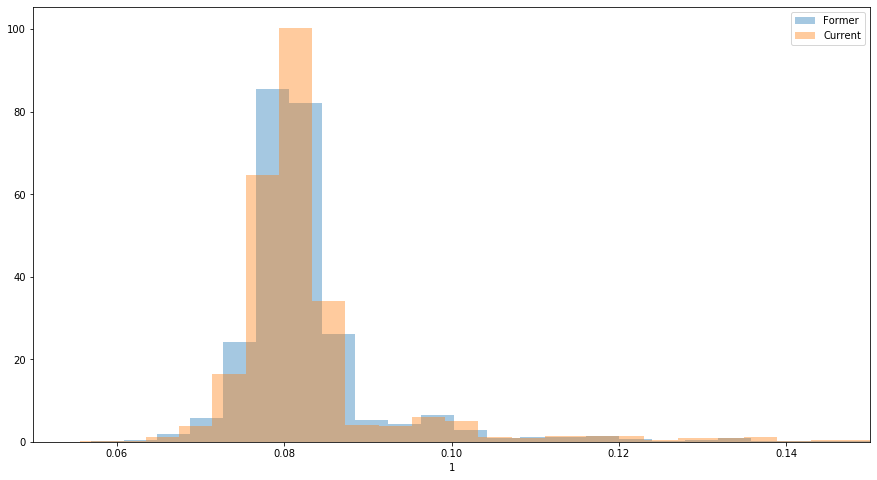

In [105]:
from scipy.stats import ttest_ind


plt.figure(figsize=(15, 8))
print(ttest_ind(df_Former[1], df_Current[1]))

sns.distplot(df_Former[1], kde=False, norm_hist=True, label="Former")
sns.distplot(df_Current[1], kde=False, norm_hist=True, label="Current")
plt.xlim([.05, .15])
plt.legend()
plt.show()

In [75]:
df_Former_Sampled = df_Former.sample(n=df_Current.shape[0], random_state=42)

print(df_Former_Sampled.shape)
print(df_Current.shape)

(13155, 15)
(13155, 15)


In [87]:
f_tot = df_Former_Sampled[5].sum()
c_tot = df_Current[5].sum()

print(f_tot)
print(c_tot)

1095.4653269182734
1089.7008991033845


In [92]:
for i in range(12):
    f_tot = df_Former_Sampled[i].sum()
    c_tot = df_Current[i].sum()
    
    print(f"Topic: {i}")
    print(f"Former: {f_tot/(f_tot+c_tot)}")
    print(f"Current: {c_tot/(f_tot+c_tot)}")   
    print()

Topic: 0
Former: 0.5008386055100164
Current: 0.4991613944899838

Topic: 1
Former: 0.4976424809556291
Current: 0.5023575190443709

Topic: 2
Former: 0.5026506816999404
Current: 0.4973493183000597

Topic: 3
Former: 0.5020358907753487
Current: 0.4979641092246513

Topic: 4
Former: 0.5003982071551807
Current: 0.49960179284481937

Topic: 5
Former: 0.5013189906896427
Current: 0.49868100931035714

Topic: 6
Former: 0.5009273366694861
Current: 0.499072663330514

Topic: 7
Former: 0.4999546605944868
Current: 0.5000453394055132

Topic: 8
Former: 0.5013881677301921
Current: 0.4986118322698079

Topic: 9
Former: 0.5004672380288564
Current: 0.49953276197114355

Topic: 10
Former: 0.4949071721324253
Current: 0.5050928278675747

Topic: 11
Former: 0.4974931550244351
Current: 0.502506844975565



Ttest_indResult(statistic=2.9970963727615563, pvalue=0.002728188046851609)


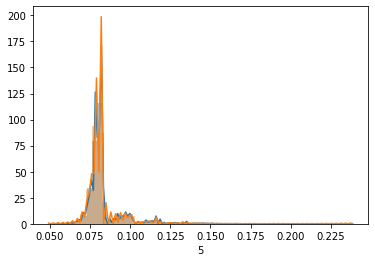

In [88]:
from scipy.stats import ttest_ind

print(ttest_ind(df_Former_Sampled[5], df_Current[5]))

sns.distplot(df_Former_Sampled[5])
sns.distplot(df_Current[5])
plt.show()

# Parameter Tuning

In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_px, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 8
max_topics = 20
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
topics_range = [12, 16]
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
# print(num_of_docs)
# corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
#                corpus]
# print(len(corpus_sets))
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(1):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append("All")
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()







  0%|          | 0/540 [00:00<?, ?it/s]





  0%|          | 1/540 [01:22<12:22:51, 82.69s/it]





  0%|          | 2/540 [02:36<11:56:32, 79.91s/it]





  1%|          | 3/540 [03:44<11:23:50, 76.41s/it]





  1%|          | 4/540 [04:52<11:01:03, 74.00s/it]





  1%|          | 5/540 [06:00<10:43:17, 72.15s/it]





  1%|          | 6/540 [09:03<15:36:49, 105.26s/it]





  1%|▏         | 7/540 [10:11<13:55:40, 94.07s/it] 





  1%|▏         | 8/540 [14:27<21:04:46, 142.64s/it]





  2%|▏         | 9/540 [23:00<37:27:40, 253.97s/it]





  2%|▏         | 10/540 [24:09<29:11:57, 198.34s/it]





  2%|▏         | 11/540 [25:27<23:49:57, 162.19s/it]





  2%|▏         | 12/540 [26:33<19:33:26, 133.35s/it]





  2%|▏         | 13/540 [27:43<16:44:07, 114.32s/it]





  3%|▎         | 14/540 [28:52<14:44:52, 100.94s/it]





  3%|▎         | 15/540 [30:03<13:24:15, 91.91s/it] 





  3%|▎         | 16/540 [31:25<12:57:00, 88.97s/it]





  3%|▎         | 17/540 [32:39<12:16

In [30]:
def lda_viz(num_topics): 

    # %%time
    # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
    num_topics = num_topics
    mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
#     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=500, random_seed=42)
#     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42,\
#                                                       alpha=.31, beta=.01)

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=.31,
                                           eta=.01,
                                           per_word_topics=True)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_px, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)


    ##mallet model to lda model conversion
#     optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

    # %%time
    # Visualize the topics
    pyLDAvis.enable_notebook()
    # vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    return vis
    # pyLDAvis.show(vis)

In [31]:
lda_viz(16)


Coherence Score:  0.4928528204955065


/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.100471  0.180210       1        1  8.207285
7      0.411998 -0.211089       2        1  7.686521
12     0.126142  0.380972       3        1  6.880241
5      0.009319  0.003490       4        1  6.452924
11    -0.040843 -0.026139       5        1  6.449244
1     -0.039364 -0.025140       6        1  6.372408
10    -0.037989 -0.024538       7        1  6.130654
15    -0.023035 -0.016950       8        1  6.099308
6     -0.040666 -0.025352       9        1  6.093709
2     -0.045233 -0.027403      10        1  6.052091
9     -0.057087 -0.031720      11        1  5.951293
4     -0.039741 -0.025201      12        1  5.944819
14    -0.078405 -0.038245      13        1  5.926785
8     -0.069980 -0.035611      14        1  5.678687
13    -0.075389 -0.037233      15        1  5.235487
3     -0.100199 -0.040051      16        1  4.838548, topic_info=      Category         Freq       Term       Total  loglift  logprob
0      Default  8011.000000    benefit  8011.00000   30.000  30.0000
22     Default  5890.000000        pay  5890.00000   29.000  29.0000
31     Default  4462.000000      peopl  4462.00000   28.000  28.0000
40     Default  4204.000000       free  4204.00000   27.000  27.0000
11     Default  3564.000000       hour  3564.00000   26.000  26.0000
...        ...          ...        ...         ...      ...      ...
4313   Topic16     0.030769       oasi     0.26748    0.866 -12.3387
4317   Topic16     0.030769     failur     0.26748    0.866 -12.3387
12923  Topic16     0.030769   properli     0.26748    0.866 -12.3387
4312   Topic16     0.030769    goodpay     0.26748    0.866 -12.3387
4311   Topic16     0.030769  cafetaria     0.26748    0.866 -12.3387

[553 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
143       9  0.955844    15_min_break
136      13  0.989709  15_minut_break
27       14  0.995897    1_hour_lunch
113       4  0.999988            abil
72        7  0.998312             abl
...     ...       ...             ...
415      15  0.989600            wide
174       5  0.997575          wonder
158       4  0.998992          worker
342       8  0.997458        workplac
416      15  0.993712           world

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 13, 6, 12, 2, 11, 16, 7, 3, 10, 5, 15, 9, 14, 4])

In [19]:
num_topics = 16

# mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=42)
lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=16, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=.31,
                                           eta=.01,
                                           per_word_topics=True)

optimal_model = lda_model

In [20]:
# Print the topics
model_topics = optimal_model.show_topics(formatted=True, num_topics=num_topics)
# pprint(optimal_model.print_topics(num_words=10))
pprint(model_topics)

[(0,
  '0.623*"free" + 0.227*"free_lunch" + 0.078*"food" + 0.022*"snack" + '
  '0.018*"friday" + 0.000*"tier" + 0.000*"benefit_onsit" + '
  '0.000*"lot_paid_time" + 0.000*"compens_benefit_packag" + 0.000*"vest"'),
 (1,
  '0.385*"time" + 0.294*"friendli" + 0.109*"worker" + 0.073*"co" + '
  '0.071*"co_worker" + 0.024*"friendli_peopl" + 0.001*"simpl" + 0.000*"globe" '
  '+ 0.000*"exactli" + 0.000*"flexibl_benefit_decent"'),
 (2,
  '0.449*"none" + 0.397*"salari" + 0.046*"steadi" + 0.024*"dont" + '
  '0.012*"futur" + 0.000*"tier" + 0.000*"benefit_onsit" + '
  '0.000*"compens_benefit_packag" + 0.000*"vest" + 0.000*"day_care_gym"'),
 (3,
  '0.509*"fun" + 0.197*"awesom" + 0.098*"interact" + 0.053*"bad" + '
  '0.012*"retail" + 0.000*"benefit_onsit" + 0.000*"lot_paid_time" + '
  '0.000*"corpor_environ" + 0.000*"tier" + 0.000*"boar"'),
 (4,
  '0.418*"flexibl" + 0.216*"product" + 0.173*"lot" + 0.090*"flexibl_hour" + '
  '0.040*"start" + 0.015*"littl" + 0.013*"space" + 0.006*"look" + '
  '0.000*"lo

In [23]:
# print(optimal_model[corpus])
# for i, (r, a, b) in enumerate(optimal_model[corpus]):
#     print(r)
doc_comp = []

for i, (row, a, b) in enumerate(optimal_model[corpus]):
    doc = [i]
    for (tn, tp) in row: 
        doc.append(tp)
    doc_comp.append(doc)
    
cols = ['Doc_Num'] 
for i in range(num_topics):
    cols.append(i)

doc_topic = pd.DataFrame(doc_comp, columns = cols)



In [25]:
doc_topic.head()

Doc_Num         0         1         2         3         4         5  \
0        0  0.034598  0.034598  0.034598  0.034598  0.034598  0.146206   
1        1  0.034599  0.034599  0.034599  0.034599  0.034599  0.034599   
2        2  0.038945  0.038945  0.038945  0.038945  0.290200  0.038945   
3        3  0.034598  0.034598  0.034598  0.034598  0.034598  0.034598   
4        4  0.023920  0.023920  0.023920  0.023920  0.023920  0.024858   

          6         7         8         9        10        11        12  \
0  0.034598  0.034598  0.034598  0.034598  0.034598  0.257810  0.034598   
1  0.034599  0.257802  0.034599  0.034599  0.034599  0.034599  0.034599   
2  0.038945  0.038945  0.164573  0.038945  0.038945  0.038945  0.038945   
3  0.034598  0.257812  0.146206  0.034598  0.034598  0.146204  0.034598   
4  0.023920  0.178241  0.101081  0.023920  0.023920  0.023920  0.408782   

         13        14        15  
0  0.034598  0.146205  0.034598  
1  0.034599  0.034599  0.257816  
2  0.038945  0.038945  0.038945  
3  0.034598  0.034598  0.034598  
4  0.023920  0.023920  0.023920

In [24]:
# doc_comp = []

# for i, row in enumerate(optimal_model[corpus]):
#     print(row)
#     doc = [i]
# #     for (tn, tp) in row: 
# #         doc.append(tp)
#     doc_comp.append(doc)
    
# cols = ['Doc_Num'] 
# for i in range(num_topics):
#     cols.append(i)

# doc_topic = pd.DataFrame(doc_comp, columns = cols)

In [ ]:
# doc_topic.head()

In [1]:
# from scipy.stats import ttest_ind

# print(ttest_ind(doc_topic[5], doc_topic[5]))

sns.distplot(doc_topic[1])
# sns.distplot(df_Current[5])
plt.show()

NameError: name 'sns' is not defined

# Hierarchical Clustering

In [36]:
# lda = optimal_model
# a = []
# for i in lda.show_topics(formatted=False,num_topics=lda.num_topics,num_words=len(lda.id2word)):
#     a.append(i)

In [39]:
# a[3]

In [41]:
phi = lda.get_topics()
# phi[:3]

In [42]:
len(phi)

16

In [44]:
num_topics = 16
from scipy.spatial import distance
# import scipy

dist = []
for i in range(num_topics): 
    t1 = phi[i]
    d1 = []
    for j in range(num_topics):
        t2 = phi[j]
        d = distance.jensenshannon(t1, t2)
        d1.append(d)
    dist.append(d1)

# print(dist)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import math

cos_sim = cosine_similarity(phi, phi)
# cos_sim = [['{:f}'.format(item) for item in item_array] for item_array in cos_sim]
# cos_sim = np.array(cos_sim)
np.set_printoptions(suppress=True)
cos_sim = np.round(cos_sim, 2)
print((len(cos_sim[0])))

16


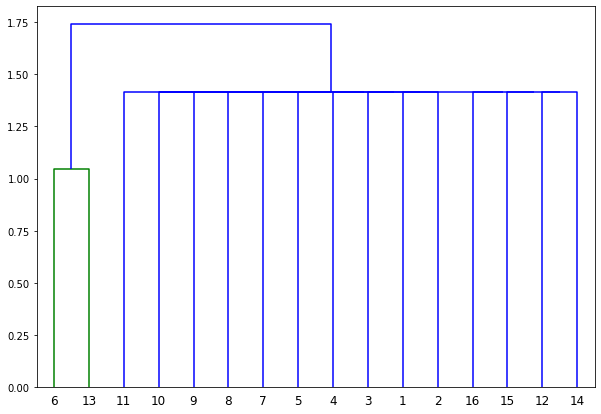

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(cos_sim, 'ward')

labelList = range(1, num_topics+1)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            show_leaf_counts=True)
plt.show()

# More Processing

In [56]:
## Dominant Topic in each documents

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_px)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(5)

KeyboardInterrupt: 

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()
# display(topic_counts)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).sort_index()
# display(topic_contribution)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by='Dominant_Topic').set_index('Dominant_Topic')
# display(topic_num_keywords)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [ ]:
df_dominant_topic.head()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(int((optimal_model.num_topics+1)/2),2,figsize=(16,14), dpi=160)

for i, ax in enumerate(axes.flatten()):   
    print(i)
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins=100, color=cols[i%10])
    ax.tick_params(axis='y', labelcolor=cols[i%10], color=cols[i%10])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i%10])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i%10]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

# Bar Plot

In [ ]:
from collections import Counter

topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_px for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
display(df.head())
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(14,14))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
#     ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i%8], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  

img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/topics_kw/pros'
img_flag = True

if not os.path.exists(img_path):
    os.makedirs(img_path)
    
if img_flag:
    plt.savefig(img_path+'/1-50_pros_600iter_10topics.png')
    
plt.show()